Simpsons Face Recognition Program (Avoid this program, use 17_simpsons_tensorflow.ipynb)
- Uses Keras 2 (tf_keras). 
- I am not sure if tf_keras is able to use the GPU.

In [2]:
# Installing `caer` and `canaro` since they don't come pre-installed
# !pip install --upgrade caer canaro
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


AttributeError: module 'tf_keras' has no attribute 'config'

In [22]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc
#pylint:disable=no-member (Removes linting problems with cv)

In [23]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'./simpsons_data/simpsons_dataset/'

In [24]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [25]:
#  Getting the first 10 categories with the most number of images
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [26]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.008109569549560547s
[INFO] At 1000 files
[INFO] 1454 files found in 0.005135774612426758s
[INFO] At 1000 files
[INFO] 1452 files found in 0.006045818328857422s
[INFO] At 1000 files
[INFO] 1354 files found in 0.006384134292602539s
[INFO] At 1000 files
[INFO] 1342 files found in 0.0052907466888427734s
[INFO] At 1000 files
[INFO] 1291 files found in 0.004122495651245117s
[INFO] At 1000 files
[INFO] 1206 files found in 0.005000591278076172s
[INFO] At 1000 files
[INFO] 1194 files found in 0.0051229000091552734s
[INFO] At 1000 files
[INFO] 1193 files found in 0.003407001495361328s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0030906200408935547s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 27s


In [27]:
# Number of training samples
len(train)

13811

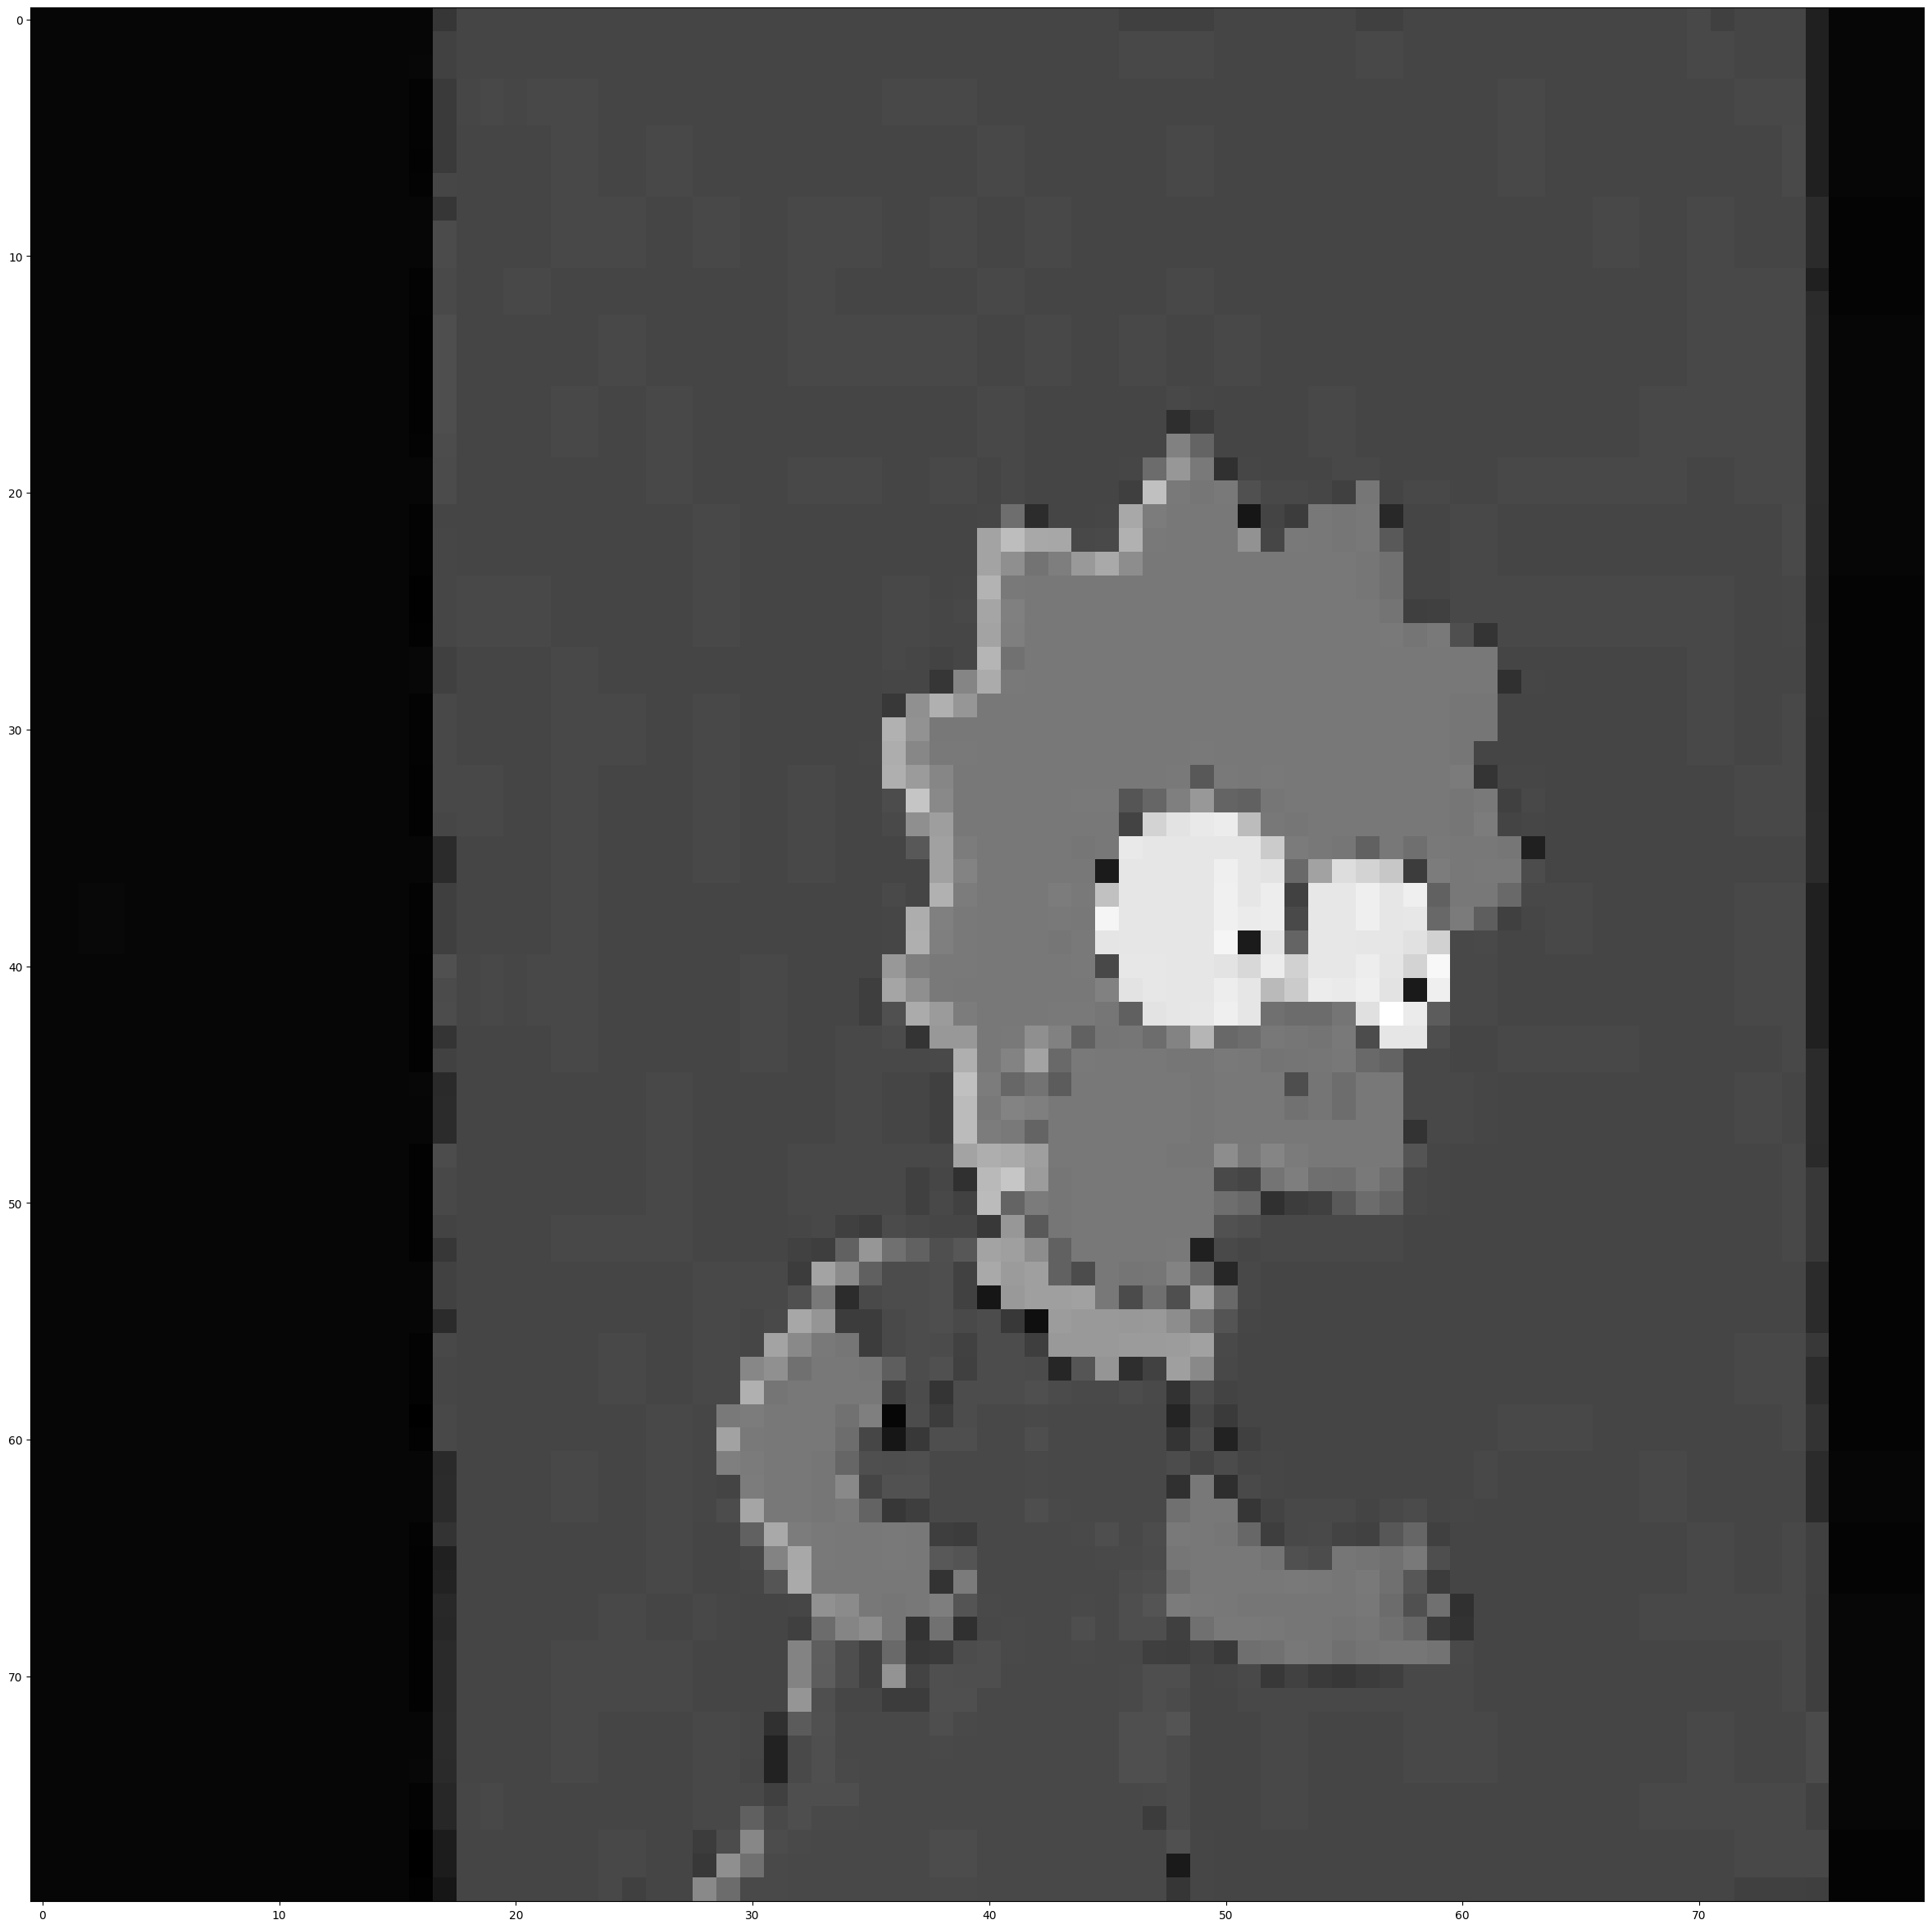

In [28]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [29]:
# Separating the array and corresponding labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [30]:
from tf_keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors
labels = to_categorical(labels, len(characters))

In [31]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [32]:
del train
del featureSet
del labels 
gc.collect()

0

In [33]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [34]:
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [35]:
# Create our model (returns a compiled model)
from tf_keras.models import Sequential
from tf_keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 39, 39, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        36928     
                                                        

In [37]:
from tf_keras.optimizers.legacy import SGD
optimizer = SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [38]:
# Training the model

from tf_keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 163s 469ms/step - loss: 0.3389 - accuracy: 0.1552 - val_loss: 0.3328 - val_accuracy: 0.1577 - lr: 0.0100
Epoch 2/10
237/345 [===================>..........] - ETA: 48s - loss: 0.3235 - accuracy: 0.1639

KeyboardInterrupt: 

In [8]:
characters

NameError: name 'characters' is not defined

## Testing

In [ ]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_0.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [ ]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [ ]:
predictions = model.predict(prepare(img))

In [ ]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])